In [ ]:
import torch
from pathlib import Path
import numpy as np
import cv2
from matplotlib import pyplot as plt

# YOLOv5 imports
from models.experimental import attempt_load
from utils.general import non_max_suppression, scale_boxes
from utils.augmentations import letterbox

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

# Assuming YOLOv5's utils and models are in the Python path

# Replace with the path to your YOLOv5 model weights
weights_path = './runs/train/exp3/weights/best.pt'

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = attempt_load(weights_path, device=device)
stride = int(model.stride.max())

def detect_and_crop_objects(image_path, conf_thres=0.25, iou_thres=0.45, imgsz=640):
    # Load image
    img0 = cv2.imread(image_path)
    assert img0 is not None, f'Image Not Found {image_path}'

    # Padded resize
    img = letterbox(img0, imgsz, stride=stride)[0]

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)

    # To device
    img = torch.from_numpy(img).to(device)
    img = img.float() / 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    pred = model(img, augment=False)[0]

    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres)

    cropped_images = []

    # Process detections
    for i, det in enumerate(pred):
        if len(det):
            # Rescale boxes
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()

            for *xyxy, conf, cls in reversed(det):
                x1, y1, x2, y2 = map(int, xyxy)
                cropped_img = img0[y1:y2, x1:x2]
                cropped_images.append(cropped_img)

    return cropped_images

# Update the path to your image
image_path = '../WhatsApp Image 2024-02-29 at 10.52.07_53200468.jpg'
cropped_images = detect_and_crop_objects(image_path)

for i, cropped_img in enumerate(cropped_images):
    # Save each cropped image
    save_path = f'cropped_15.jpg'
    cv2.imwrite(save_path, cropped_img)
    print(f"Cropped Image {i+1} saved as {save_path}.")

    # Display each cropped image
    plt.figure()
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Cropped Image {i+1}')
    plt.axis('off')

plt.show()

In [4]:
import cv2
import torch
import pandas as pd
from models.experimental import attempt_load

# Correctly set paths for compatibility on non-Unix systems
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

# Load the model
# # Model weights path
# weights_path = './runs/train/exp37/weights/best.pt'  # Update this path as necessary

# # Determine device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load the trained model without specifying map_location
# model = attempt_load(weights_path, device=device)  # Load the trained model

model = torch.hub.load('ultralytics/yolov5', 'custom', path='./runs/train/exp37/weights/best.pt')

# Load and prepare the image
img_path = './cropped_15.jpg'
img = cv2.imread(img_path)  # Use cv2 to read the image

# Preprocessing steps

# Convert to grayscale (if beneficial for your model and text visibility)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur (optional, can help with thresholding)
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

## Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for CLAHE
img_clahe = clahe.apply(img_gray)
img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2BGR)  # Convert back to BGR for YOLO

# Perform inference, the model can handle BGR images directly
results = model(img_clahe)

# Filter detections with confidence > 0.6
filtered_results = results.xyxy[0][results.xyxy[0][:, 4] > 0.6]

# Sort the filtered results horizontally by the x-axis of the bounding box
sorted_filtered_results = filtered_results[filtered_results[:, 0].argsort()]

# Extracting details for display
detections = sorted_filtered_results.cpu().numpy()

# Display detections in a tabular format
df = pd.DataFrame(detections[:, :6], columns=['X1', 'Y1', 'X2', 'Y2', 'Confidence', 'Class'])
df['Class'] = [model.names[int(cls)] for cls in detections[:, -1]]
print(df)

# Draw bounding boxes on the original image (not preprocessed) to maintain original colors and details
for det in detections:
    x1, y1, x2, y2 = map(int, det[:4])
    conf, cls_id = det[4], int(det[5])
    label = f"{model.names[cls_id]}: {conf:.2f}"
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Extract class names in the order of sorted detections by X1
sorted_class_names = [model.names[int(cls)] for cls in sorted_filtered_results[:, -1]]

# Combine class names into a single string, preserving their left-to-right order in the image
combined_classes_text = ''.join(sorted_class_names)

# Print the combined class names in their sorted order
print(f"Detected classes (sorted by X1): {combined_classes_text}")

# Display the image with bounding boxes
cv2.imshow('Detected Objects', img)
cv2.waitKey(0)  # Wait for a key press to close the image window
cv2.destroyAllWindows()  # Close the image window


Using cache found in C:\Users\Faturrahman/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  v7.0-283-g875d927 Python-3.10.0 torch-1.12.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7107217 parameters, 0 gradients, 16.1 GFLOPs
Adding AutoShape... 


           X1         Y1          X2          Y2  Confidence Class
0   21.528757  19.777624  113.713257  172.219391    0.825490     H
1  191.072647  34.018536  282.127747  169.213257    0.868167     5
2  291.148804  34.507652  358.707703  181.828445    0.791430     1
3  366.678223  44.187080  448.252563  184.962769    0.853989     4
4  446.419647  50.885296  539.337463  196.600052    0.821399     9
5  591.659424  53.935944  681.143311  203.248962    0.841919     A
6  683.382874  62.386349  764.306641  197.301910    0.750615     G
7  765.626465  60.750446  859.327271  203.791245    0.859519     C
Detected classes (sorted by X1): H5149AGC


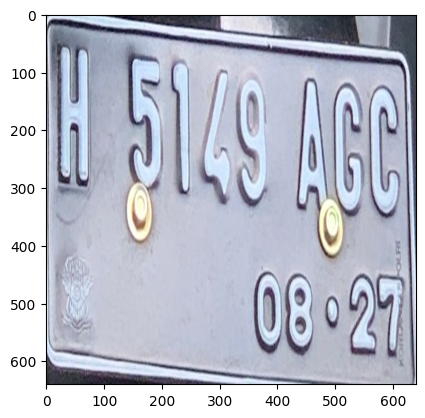

Red Channel Matrix:
[[  7  71 146 ...  66  62  56]
 [ 34  97 159 ...  66  62  57]
 [ 86 146 181 ...  64  64  59]
 ...
 [ 23  37  36 ... 190 216 216]
 [ 27  42  36 ... 202 213 217]
 [ 30  45  36 ... 209 211 217]]

Green Channel Matrix:
[[ 24  89 166 ...  75  71  65]
 [ 51 115 178 ...  75  71  66]
 [103 164 200 ...  73  73  68]
 ...
 [ 21  35  34 ... 195 222 224]
 [ 26  40  34 ... 208 219 226]
 [ 28  43  34 ... 215 218 226]]

Blue Channel Matrix:
[[ 44 107 182 ...  84  80  74]
 [ 71 132 195 ...  84  80  75]
 [123 181 217 ...  82  82  77]
 ...
 [ 24  38  37 ... 207 234 235]
 [ 29  43  37 ... 220 231 236]
 [ 31  46  37 ... 227 230 237]]


In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and resize the image
image_path = './cropped_15.jpg'  # Update this to the path of your image
original_img = Image.open(image_path)
resized_img = original_img.resize((640, 640))

# Convert the PIL image to a numpy array
img_array = np.array(resized_img)

# Display the resized image
plt.imshow(img_array)
plt.show()

# Print the RGB matrices
print("Red Channel Matrix:")
print(img_array[:, :, 0])  # Red channel
print("\nGreen Channel Matrix:")
print(img_array[:, :, 1])  # Green channel
print("\nBlue Channel Matrix:")
print(img_array[:, :, 2])  # Blue channel


In [2]:
# Define the convolution results for the top-left pixel for each channel
R_conv = 104.5
G_conv = 139.5
B_conv = 177.0

# Define example parameters for batch normalization for demonstration purposes.
# Normally, these parameters are learned during the training process of the neural network.
gamma = 1.0  # scale factor, usually close to 1
beta = 0.0   # offset, usually close to 0
mean = np.mean([R_conv, G_conv, B_conv])  # the mean of the values
variance = np.var([R_conv, G_conv, B_conv])  # the variance of the values
epsilon = 1e-5  # small constant to prevent division by zero

# Apply batch normalization for each channel
def batch_normalize(x, mean, variance, gamma, beta, epsilon):
    return gamma * ((x - mean) / np.sqrt(variance + epsilon)) + beta

R_bn = batch_normalize(R_conv, mean, variance, gamma, beta, epsilon)
G_bn = batch_normalize(G_conv, mean, variance, gamma, beta, epsilon)
B_bn = batch_normalize(B_conv, mean, variance, gamma, beta, epsilon)

# Define the SiLU (Swish) activation function
def silu(x):
    return x / (1.0 + np.exp(-x))

# Apply the SiLU activation function to the batch-normalized values
R_activated = silu(R_bn)
G_activated = silu(G_bn)
B_activated = silu(B_bn)

R_activated, G_activated, B_activated


(-0.27794492097177464, -0.013876652992651348, 0.9602888011095638)

In [3]:
# Given convolved values and their mean
R_conv = 104.5
G_conv = 139.5
B_conv = 177
mean_conv = 140.33

# Calculate the variance manually
variance = ((R_conv - mean_conv)**2 + (G_conv - mean_conv)**2 + (B_conv - mean_conv)**2) / 3

variance


876.3889

In [4]:
# Define the batch-normalized values
BN_R_conv = -1.210
BN_G_conv = -0.028
BN_B_conv = 1.239

# Define the SiLU function
def silu(x):
    return x / (1.0 + np.exp(-x))

# Apply the SiLU function to the batch-normalized values
SiLU_R_conv = silu(BN_R_conv)
SiLU_G_conv = silu(BN_G_conv)
SiLU_B_conv = silu(BN_B_conv)

SiLU_R_conv, SiLU_G_conv, SiLU_B_conv


(-0.27793827165361173, -0.013804012804329475, 0.960708088367891)